In [1]:
!pip install pyspark
!pip install datetime
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=3ae810fd9f892806a3d33a504b75db5ee79ebffebb0ca817e5f95080a9d66852
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.1/247.1 kB 8.4 MB/s eta 0:00:00


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import MapType,StringType
from pyspark.sql.functions import from_json
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt

# Fix the Artist data

Read the CSV data

In [3]:
url = 'https://media.githubusercontent.com/media/MuseumofModernArt/collection/master/Artists.csv'
artist = pd.read_csv(url, index_col= 0)

Check for null values

In [4]:
artist.isnull().sum()

DisplayName        0
ArtistBio       2215
Nationality     2472
Gender          3165
BeginDate          0
EndDate            0
Wiki QID       11994
ULAN           12311
dtype: int64

Drop the ULAN and Wiki QID column

In [5]:
columns = ['ULAN', 'Wiki QID']
artist = artist.drop(columns=columns)

In [6]:
artist.isnull().sum()

DisplayName       0
ArtistBio      2215
Nationality    2472
Gender         3165
BeginDate         0
EndDate           0
dtype: int64

In [7]:
artist.head(20)

,DisplayName,ArtistBio,Nationality,Gender,BeginDate,EndDate
ConstituentID,,,,,,
1,Robert Arneson,"American, 1930–1992",American,Male,1930,1992
2,Doroteo Arnaiz,"Spanish, born 1936",Spanish,Male,1936,0
3,Bill Arnold,"American, born 1941",American,Male,1941,0
4,Charles Arnoldi,"American, born 1946",American,Male,1946,0
5,Per Arnoldi,"Danish, born 1941",Danish,Male,1941,0
6,Danilo Aroldi,"Italian, born 1925",Italian,Male,1925,0
7,Bill Aron,"American, born 1941",American,Male,1941,0
9,David Aronson,"American, born Lithuania 1923",American,Male,1923,0
10,Irene Aronson,"American, born Germany 1918",American,Female,1918,0


STEPS:
  split the artist bio column over , space and -
  for values in the list that have the same strings as lis, append the string value to nationality if the nationality column is null

In [8]:
lis = artist['Nationality'].unique()

In [9]:
print(lis)

['American' 'Spanish' 'Danish' 'Italian' 'French' 'Estonian' 'Mexican'
 'Swedish' nan 'Israeli' 'British' 'Finnish' 'Polish' 'Palestinian'
 'Japanese' 'Guatemalan' 'Colombian' 'Romanian' 'Russian' 'German'
 'Argentine' 'Kuwaiti' 'Belgian' 'Dutch' 'Norwegian' 'Nationality unknown'
 'Chilean' 'Swiss' 'Costa Rican' 'Czech' 'Brazilian' 'Austrian' 'Canadian'
 'Australian' 'Ukrainian' 'Hungarian' 'Haitian' 'Congolese' 'Bolivian'
 'Cuban' 'Slovenian' 'Portuguese' 'Indian' 'Peruvian' 'Icelandic' 'Irish'
 'Croatian' 'Uruguayan' 'Slovak' 'Greek' 'Chinese' 'Venezuelan'
 'Native American' 'Turkish' 'Panamanian' 'Algerian' 'Ecuadorian'
 'South African' 'Iranian' 'Korean' 'Serbian' 'Canadian Inuit'
 'Paraguayan' 'Luxembourger' 'Nicaraguan' 'Zimbabwean' 'Moroccan'
 'Tanzanian' 'Bulgarian' 'Tunisian' 'Sudanese' 'Taiwanese' 'Ethiopian'
 'Yugoslav' 'Scottish' 'Latvian' 'Azerbaijani' 'Senegalese' 'Thai'
 'New Zealander' 'Lithuanian' 'Pakistani' 'Bahamian' 'Bosnian' 'Malian'
 'Czechoslovakian' 'Georgian' 

In [10]:
artistdf = artist
for index, row in artistdf.iterrows():
    if pd.isna(row['Nationality']):
        bio_elements = re.split('[,– ]+', str(row['ArtistBio']))
        if [element for element in bio_elements if element in lis]:
            artistdf.at[index, 'Nationality'] = ', '.join([element for element in bio_elements if element in lis])

In [11]:
artistdf.isnull().sum()

DisplayName       0
ArtistBio      2215
Nationality    2396
Gender         3165
BeginDate         0
EndDate           0
dtype: int64

In [12]:
artist['Gender'] = artist['Gender'].replace(np.nan, 'Do not identify')

In [13]:
artistdf['Gender'] = artistdf['Gender'].str.lower()

In [14]:
artistdf['Gender'].unique()

array(['male', 'female', 'do not identify', 'non-binary'], dtype=object)

In [15]:
artistdf["Nationality"].isnull().sum()

2396

In [16]:
df = artistdf.dropna()

In [17]:
df.shape

(12695, 6)

In [18]:
df.isna().sum()

DisplayName    0
ArtistBio      0
Nationality    0
Gender         0
BeginDate      0
EndDate        0
dtype: int64

In [19]:
df.iloc[300:350]

,DisplayName,ArtistBio,Nationality,Gender,BeginDate,EndDate
ConstituentID,,,,,,
350,Thomas F. Barrow,"American, born 1938",American,male,1938,0
351,David Francis Barry,"American, 1854–1934",American,male,1854,1934
352,Robert Barry,"American, born 1936",American,male,1936,0
353,Robert Bart,"American, born Canada 1923",American,male,1923,0
354,Frances Barth,"American, born 1946",American,female,1946,0
355,Ruodi Barth,"Swiss, 1921–1999",Swiss,male,1921,1999
356,"Ralph Bartholomew, Jr.","American, 1907–1985",American,male,1907,1985
357,Jennifer Bartlett,"American, 1941–2022",American,female,1941,2022
358,Robert Bartlett,"British, 1922–1979",British,male,1922,1979


## Remove special characters at the beginning or end of the name

In [20]:
df['DisplayName'] = df['DisplayName'].str.lstrip('&#$^&*!@:"?><').str.rstrip('&#$^&*!@:"?><')

<ipython-input-20-02e792efaadf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DisplayName'] = df['DisplayName'].str.lstrip('&#$^&*!@:"?><').str.rstrip('&#$^&*!@:"?><')


In [21]:
df.iloc[300:350]

,DisplayName,ArtistBio,Nationality,Gender,BeginDate,EndDate
ConstituentID,,,,,,
350,Thomas F. Barrow,"American, born 1938",American,male,1938,0
351,David Francis Barry,"American, 1854–1934",American,male,1854,1934
352,Robert Barry,"American, born 1936",American,male,1936,0
353,Robert Bart,"American, born Canada 1923",American,male,1923,0
354,Frances Barth,"American, born 1946",American,female,1946,0
355,Ruodi Barth,"Swiss, 1921–1999",Swiss,male,1921,1999
356,"Ralph Bartholomew, Jr.","American, 1907–1985",American,male,1907,1985
357,Jennifer Bartlett,"American, 1941–2022",American,female,1941,2022
358,Robert Bartlett,"British, 1922–1979",British,male,1922,1979


# Fix the Artworks Data

In [22]:
url = 'https://media.githubusercontent.com/media/MuseumofModernArt/collection/master/Artworks.csv'
artwork = pd.read_csv(url, index_col= 0)

In [23]:
artwork.shape

(140848, 28)

In [24]:
print(artwork.dtypes)

Artist                 object
ConstituentID          object
ArtistBio              object
Nationality            object
BeginDate              object
EndDate                object
Gender                 object
Date                   object
Medium                 object
Dimensions             object
CreditLine             object
AccessionNumber        object
Classification         object
Department             object
DateAcquired           object
Cataloged              object
ObjectID                int64
URL                    object
ThumbnailURL           object
Circumference (cm)    float64
Depth (cm)            float64
Diameter (cm)         float64
Height (cm)           float64
Length (cm)           float64
Weight (kg)           float64
Width (cm)            float64
Seat Height (cm)      float64
Duration (sec.)       float64
dtype: object


In [25]:
artwork['Date']

Title
Ferdinandsbrücke Project, Vienna, Austria (Elevation, preliminary version)                                          1896
City of Music, National Superior Conservatory of Music and Dance, Paris, France, View from interior courtyard       1987
Villa near Vienna Project, Outside Vienna, Austria, Elevation                                                       1903
The Manhattan Transcripts Project, New York, New York, Introductory panel to Episode 1: The Park                    1980
Villa, project, outside Vienna, Austria, Exterior perspective                                                       1903
                                                                                                                  ...   
Page from Sketchbook #24, New York City                                                                          1954-55
Page from Sketchbook #24, New York City                                                                          1954-55
Page from Sketchbook #24, 

In [26]:
col = ['Seat Height (cm)', 'Duration (sec.)', 'Weight (kg)', 'Diameter (cm)', 'Circumference (cm)', 'Depth (cm)']
artworkdf = artwork.drop(columns = col)

In [27]:
artworkdf.isna().sum()

Artist               1216
ConstituentID        1216
ArtistBio            5825
Nationality          1216
BeginDate            1216
EndDate              1216
Gender               1216
Date                 2105
Medium               9631
Dimensions           9252
CreditLine           1863
AccessionNumber         0
Classification          1
Department              0
DateAcquired         6682
Cataloged               0
ObjectID                0
URL                 46692
ThumbnailURL        57499
Height (cm)         16981
Length (cm)        140106
Width (cm)          17902
dtype: int64

In [28]:
artworkdf.head(20)

,Artist,ConstituentID,ArtistBio,Nationality,BeginDate,EndDate,Gender,Date,Medium,Dimensions,...,Classification,Department,DateAcquired,Cataloged,ObjectID,URL,ThumbnailURL,Height (cm),Length (cm),Width (cm)
Title,,,,,,,,,,,,,,,,,,,,,
"Ferdinandsbrücke Project, Vienna, Austria (Elevation, preliminary version)",Otto Wagner,6210,"(Austrian, 1841–1918)",(Austrian),(1841),(1918),(Male),1896,Ink and cut-and-pasted painted pages on paper,"19 1/8 x 66 1/2"" (48.6 x 168.9 cm)",...,Architecture,Architecture & Design,1996-04-09,Y,2,http://www.moma.org/collection/works/2,http://www.moma.org/media/W1siZiIsIjUyNzc3MCJd...,48.6000,NaN,168.9000
"City of Music, National Superior Conservatory of Music and Dance, Paris, France, View from interior courtyard",Christian de Portzamparc,7470,"(French, born 1944)",(French),(1944),(0),(Male),1987,Paint and colored pencil on print,"16 x 11 3/4"" (40.6 x 29.8 cm)",...,Architecture,Architecture & Design,1995-01-17,Y,3,http://www.moma.org/collection/works/3,http://www.moma.org/media/W1siZiIsIjUyNzM3NCJd...,40.6401,NaN,29.8451
"Villa near Vienna Project, Outside Vienna, Austria, Elevation",Emil Hoppe,7605,"(Austrian, 1876–1957)",(Austrian),(1876),(1957),(Male),1903,"Graphite, pen, color pencil, ink, and gouache ...","13 1/2 x 12 1/2"" (34.3 x 31.8 cm)",...,Architecture,Architecture & Design,1997-01-15,Y,4,http://www.moma.org/collection/works/4,http://www.moma.org/media/W1siZiIsIjUyNzM3NSJd...,34.3000,NaN,31.8000
"The Manhattan Transcripts Project, New York, New York, Introductory panel to Episode 1: The Park",Bernard Tschumi,7056,"(French and Swiss, born Switzerland 1944)",(),(1944),(0),(Male),1980,Photographic reproduction with colored synthet...,"20 x 20"" (50.8 x 50.8 cm)",...,Architecture,Architecture & Design,1995-01-17,Y,5,http://www.moma.org/collection/works/5,http://www.moma.org/media/W1siZiIsIjUyNzQ3NCJd...,50.8000,NaN,50.8000
"Villa, project, outside Vienna, Austria, Exterior perspective",Emil Hoppe,7605,"(Austrian, 1876–1957)",(Austrian),(1876),(1957),(Male),1903,"Graphite, color pencil, ink, and gouache on tr...","15 1/8 x 7 1/2"" (38.4 x 19.1 cm)",...,Architecture,Architecture & Design,1997-01-15,Y,6,http://www.moma.org/collection/works/6,http://www.moma.org/media/W1siZiIsIjUyNzQ3NSJd...,38.4000,NaN,19.1000
"The Manhattan Transcripts Project, New York, New York, Episode 1: The Park",Bernard Tschumi,7056,"(French and Swiss, born Switzerland 1944)",(),(1944),(0),(Male),1976-77,Gelatin silver photograph,"14 x 18"" (35.6 x 45.7 cm)",...,Architecture,Architecture & Design,1995-01-17,Y,7,http://www.moma.org/collection/works/7,http://www.moma.org/media/W1siZiIsIjUyNzUyMCJd...,35.6000,NaN,45.7000
"The Manhattan Transcripts Project, New York, New York, Episode 1: The Park",Bernard Tschumi,7056,"(French and Swiss, born Switzerland 1944)",(),(1944),(0),(Male),1976-77,Gelatin silver photographs,"Each: 14 x 18"" (35.6 x 45.7 cm)",...,Architecture,Architecture & Design,1995-01-17,Y,8,http://www.moma.org/collection/works/8,http://www.moma.org/media/W1siZiIsIjUyNzUyMyJd...,35.6000,NaN,45.7000
"The Manhattan Transcripts Project, New York, New York, Episode 1: The Park",Bernard Tschumi,7056,"(French and Swiss, born Switzerland 1944)",(),(1944),(0),(Male),1976-77,Gelatin silver photograph,"14 x 18"" (35.6 x 45.7 cm)",...,Architecture,Architecture & Design,1995-01-17,Y,9,http://www.moma.org/collection/works/9,NaN,35.6000,NaN,45.7000
"The Manhattan Transcripts Project, New York, New York, Episode 1: The Park",Bernard Tschumi,7056,"(French and Swiss, born Switzerland 1944)",(),(1944),(0),(Male),1976-77,Gelatin silver photograph,"14 x 18"" (35.6 x 45.7 cm)",...,Architecture,Architecture & Design,1995-01-17,Y,10,http://www.moma.org/collection/works/10,http://www.moma.org/media/W1siZiIsIjUyNzUyMSJd...,35.6000,NaN,45.7000


# UNIVARIATE ANALYSIS FOR ARTIST

In [29]:
df.head()

,DisplayName,ArtistBio,Nationality,Gender,BeginDate,EndDate
ConstituentID,,,,,,
1,Robert Arneson,"American, 1930–1992",American,male,1930,1992
2,Doroteo Arnaiz,"Spanish, born 1936",Spanish,male,1936,0
3,Bill Arnold,"American, born 1941",American,male,1941,0
4,Charles Arnoldi,"American, born 1946",American,male,1946,0
5,Per Arnoldi,"Danish, born 1941",Danish,male,1941,0


## check for the population of artist that come from a particular nationality

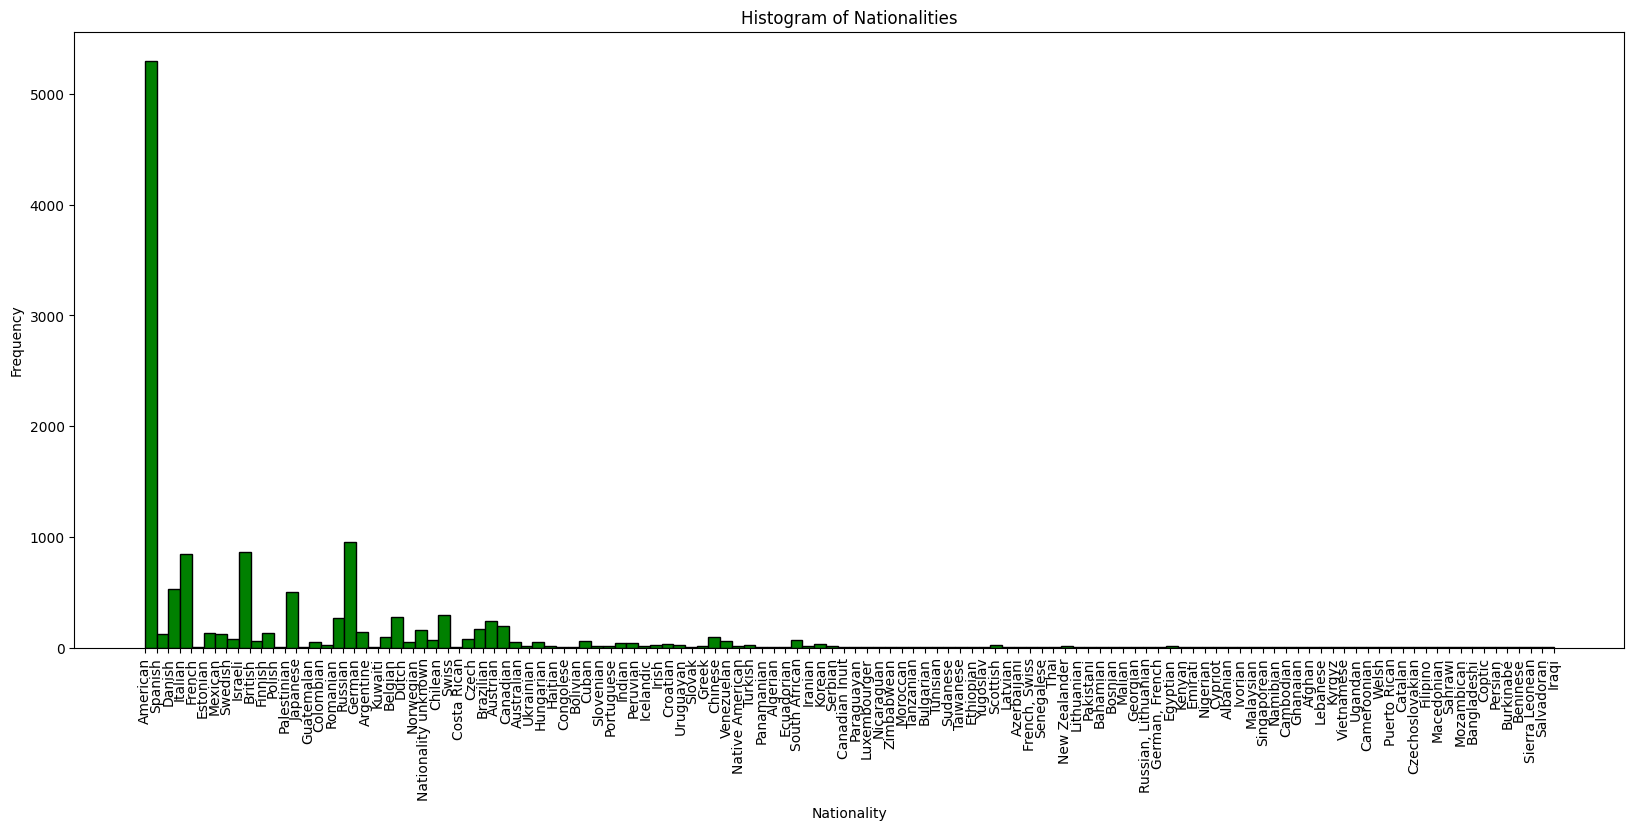

In [30]:

plt.figure(figsize=(20,8))
plt.hist(df['Nationality'], bins=120, color='green', edgecolor='black')
plt.xlabel('Nationality')
plt.ylabel('Frequency')
plt.title('Histogram of Nationalities')
plt.xticks(rotation=90)
plt.show()

## check for the population of artist gender


In [31]:
gender_counts = df['Gender'].value_counts()

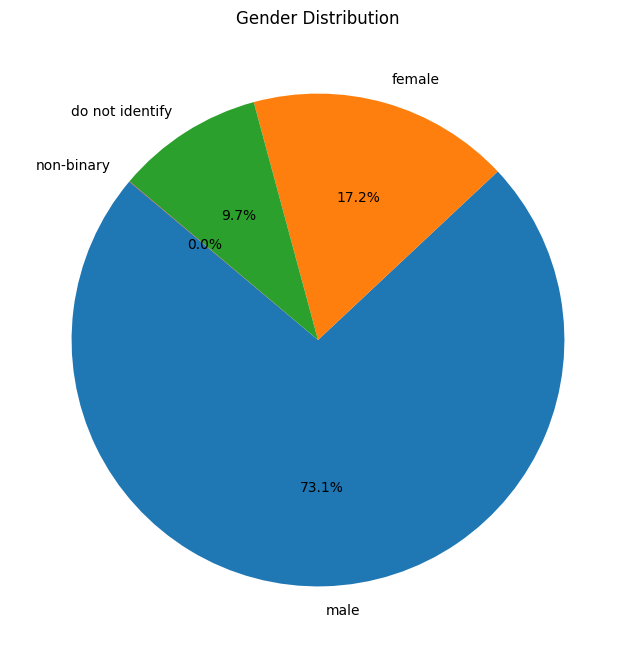

In [32]:
plt.figure(figsize=(8, 8))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Gender Distribution')
plt.show()

In [33]:
df['BeginDate'] = df['BeginDate'].replace(0, np.nan)
df['EndDate'] = df['EndDate'].replace(0, np.nan)

<ipython-input-33-43caaa3be824>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BeginDate'] = df['BeginDate'].replace(0, np.nan)
<ipython-input-33-43caaa3be824>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EndDate'] = df['EndDate'].replace(0, np.nan)


In [34]:
df['BeginDate'] = df['BeginDate'].apply(lambda x: np.nan if x < 1700 else x)
df['EndDate'] = df['EndDate'].apply(lambda x: np.nan if x < 1700 else x)

<ipython-input-34-ea1ffe463f9c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BeginDate'] = df['BeginDate'].apply(lambda x: np.nan if x < 1700 else x)
<ipython-input-34-ea1ffe463f9c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EndDate'] = df['EndDate'].apply(lambda x: np.nan if x < 1700 else x)


<ipython-input-35-99c7041266f3>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['EndDate'])


<Axes: xlabel='EndDate', ylabel='Density'>

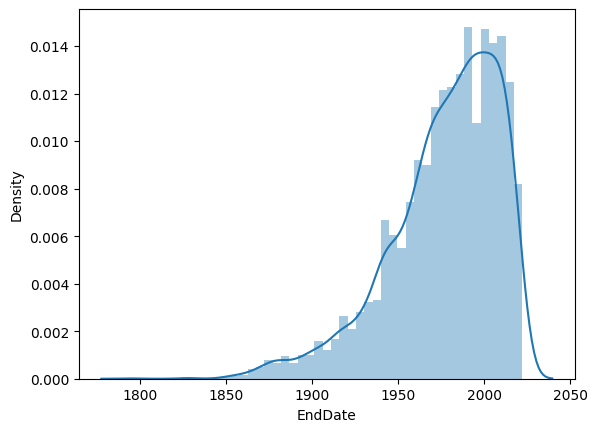

In [35]:
sns.distplot(df['EndDate'])

Distribution for the date of births

<ipython-input-36-4b7e0775a71d>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['BeginDate'])


<Axes: xlabel='BeginDate', ylabel='Density'>

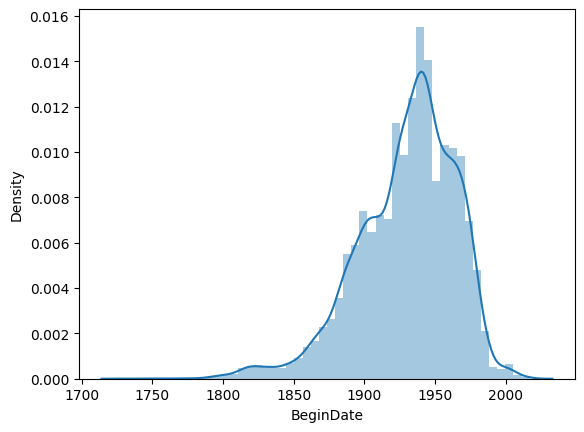

In [36]:
sns.distplot(df['BeginDate'])

# BIVARIATE ANALYSIS FOR ARTIST

check for the artist that lived the longest and shortest(age bracket)

<Axes: xlabel='Age_Category', ylabel='count'>

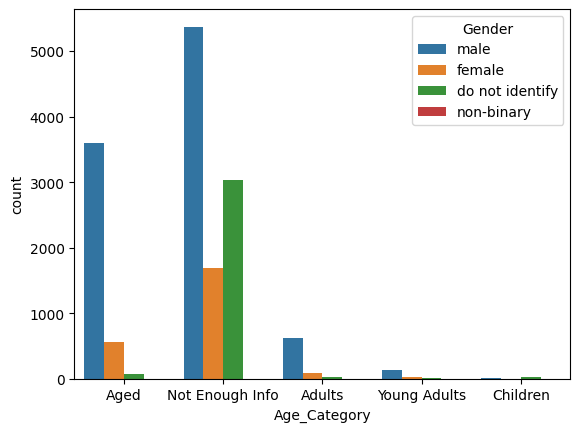

In [79]:
artistdf['Age'] = artistdf['EndDate'] - artistdf['BeginDate']
artistdf['Age']
artistdf['Age_Category'] = 0

artistdf.loc[artistdf['Age']<=0,'Age_Category'] = 'Not Enough Info'
artistdf.loc[(artistdf['Age']>0) & (artistdf['Age']<18),'Age_Category'] = 'Children'
artistdf.loc[(artistdf['Age']>=18) & (artistdf['Age']<40),'Age_Category'] = 'Young Adults'
artistdf.loc[(artistdf['Age']>=40) & (artistdf['Age']<60),'Age_Category'] = 'Adults'
artistdf.loc[(artistdf['Age']>=60) & (artistdf['Age']<=108),'Age_Category'] = 'Aged'
artistdf.loc[artistdf['Age']>108,'Age_Category'] = 'Not Enough Info'
sns.countplot(x=artistdf['Age_Category'],hue=artistdf.Gender)

# UNIVARIATE ANALYSIS FOR ARTWORK

In [37]:
artworkdf.columns

Index(['Artist', 'ConstituentID', 'ArtistBio', 'Nationality', 'BeginDate',
       'EndDate', 'Gender', 'Date', 'Medium', 'Dimensions', 'CreditLine',
       'AccessionNumber', 'Classification', 'Department', 'DateAcquired',
       'Cataloged', 'ObjectID', 'URL', 'ThumbnailURL', 'Height (cm)',
       'Length (cm)', 'Width (cm)'],
      dtype='object')

In [38]:
artworkdf['AccessionNumber']

Title
Ferdinandsbrücke Project, Vienna, Austria (Elevation, preliminary version)                                          885.1996
City of Music, National Superior Conservatory of Music and Dance, Paris, France, View from interior courtyard         1.1995
Villa near Vienna Project, Outside Vienna, Austria, Elevation                                                         1.1997
The Manhattan Transcripts Project, New York, New York, Introductory panel to Episode 1: The Park                      2.1995
Villa, project, outside Vienna, Austria, Exterior perspective                                                         2.1997
                                                                                                                    ...     
Page from Sketchbook #24, New York City                                                                          346.2020.30
Page from Sketchbook #24, New York City                                                                          346.20

## artwork classification

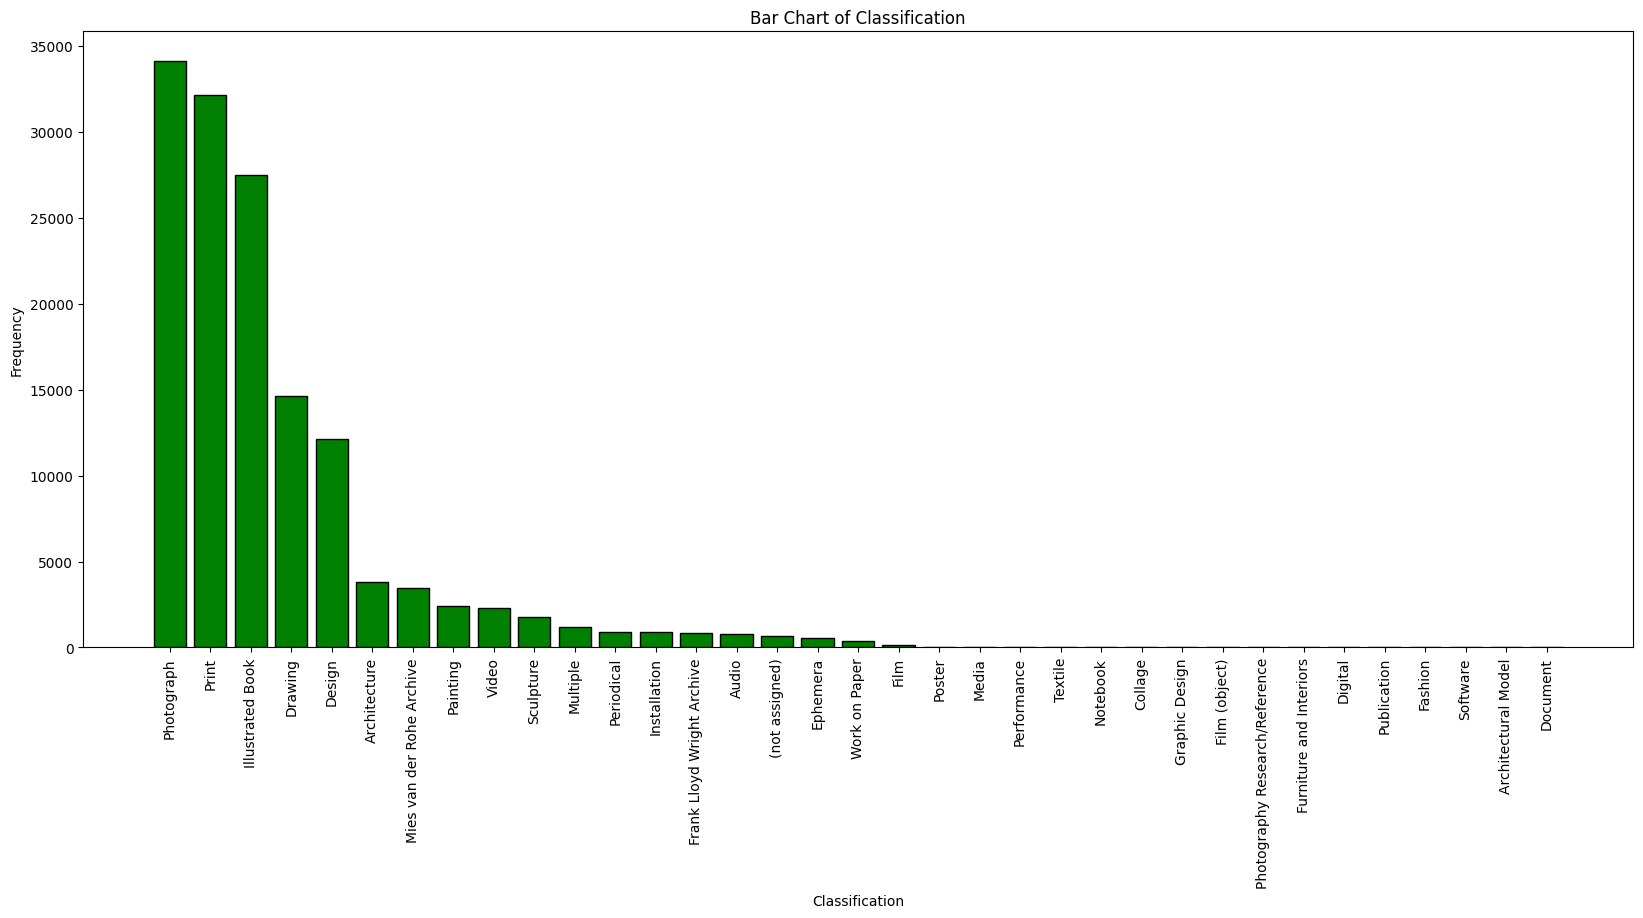

In [49]:
classification_counts = artworkdf['Classification'].value_counts()
plt.figure(figsize=(20, 8))
plt.bar(classification_counts.index, classification_counts.values, color='green', edgecolor='black')
plt.xlabel('Classification')
plt.ylabel('Frequency')
plt.title('Bar Chart of Classification')
plt.xticks(rotation=90)
plt.show()

In [40]:
artworkdf['Classification']

Title
Ferdinandsbrücke Project, Vienna, Austria (Elevation, preliminary version)                                       Architecture
City of Music, National Superior Conservatory of Music and Dance, Paris, France, View from interior courtyard    Architecture
Villa near Vienna Project, Outside Vienna, Austria, Elevation                                                    Architecture
The Manhattan Transcripts Project, New York, New York, Introductory panel to Episode 1: The Park                 Architecture
Villa, project, outside Vienna, Austria, Exterior perspective                                                    Architecture
                                                                                                                     ...     
Page from Sketchbook #24, New York City                                                                               Drawing
Page from Sketchbook #24, New York City                                                                         

In [44]:
classsification_counts = artworkdf['Classification'].value_counts()

Photograph                        34126
Print                             32143
Illustrated Book                  27491
Drawing                           14630
Design                            12133
Architecture                       3828
Mies van der Rohe Archive          3434
Painting                           2394
Video                              2301
Sculpture                          1745
Multiple                           1175
Periodical                          927
Installation                        885
Frank Lloyd Wright Archive          869
Audio                               793
(not assigned)                      678
Ephemera                            544
Work on Paper                       373
Film                                159
Poster                               47
Media                                40
Performance                          30
Textile                              30
Notebook                             27
Collage                              24


## Statistical data for the width

In [51]:
mean_width = artworkdf['Width (cm)'].mean()
median_width = artworkdf['Width (cm)'].median()
std_dev_width = artworkdf['Width (cm)'].std()
variance_width = artworkdf['Width (cm)'].var()
range_width = artworkdf['Width (cm)'].max() - artworkdf['Width (cm)'].min()


print("Mean Width:", mean_width)
print("Median Width:", median_width)
print("Standard Deviation of Width:", std_dev_width)
print("Variance of Width:", variance_width)
print("Range of Width:", range_width)


Mean Width: 37.81914068877903
Median Width: 25.4
Standard Deviation of Width: 66.96565881304448
Variance of Width: 4484.399460265082
Range of Width: 9144.0


## Statistical data for the Height

In [52]:
mean_height = artworkdf['Height (cm)'].mean()
median_height = artworkdf['Height (cm)'].median()
std_dev_height = artworkdf['Height (cm)'].std()
variance_height = artworkdf['Height (cm)'].var()
range_height = artworkdf['Height (cm)'].max() - artworkdf['Height (cm)'].min()

print("Mean Height:", mean_height)
print("Median Height:", median_height)
print("Standard Deviation of Height:", std_dev_height)
print("Variance of Height:", variance_height)
print("Range of Height:", range_height)

Mean Height: 37.355051130016015
Median Height: 27.7
Standard Deviation of Height: 49.32087614984777
Variance of Height: 2432.5488241886223
Range of Height: 9140.0


## Top 10 artist with the most Artwork

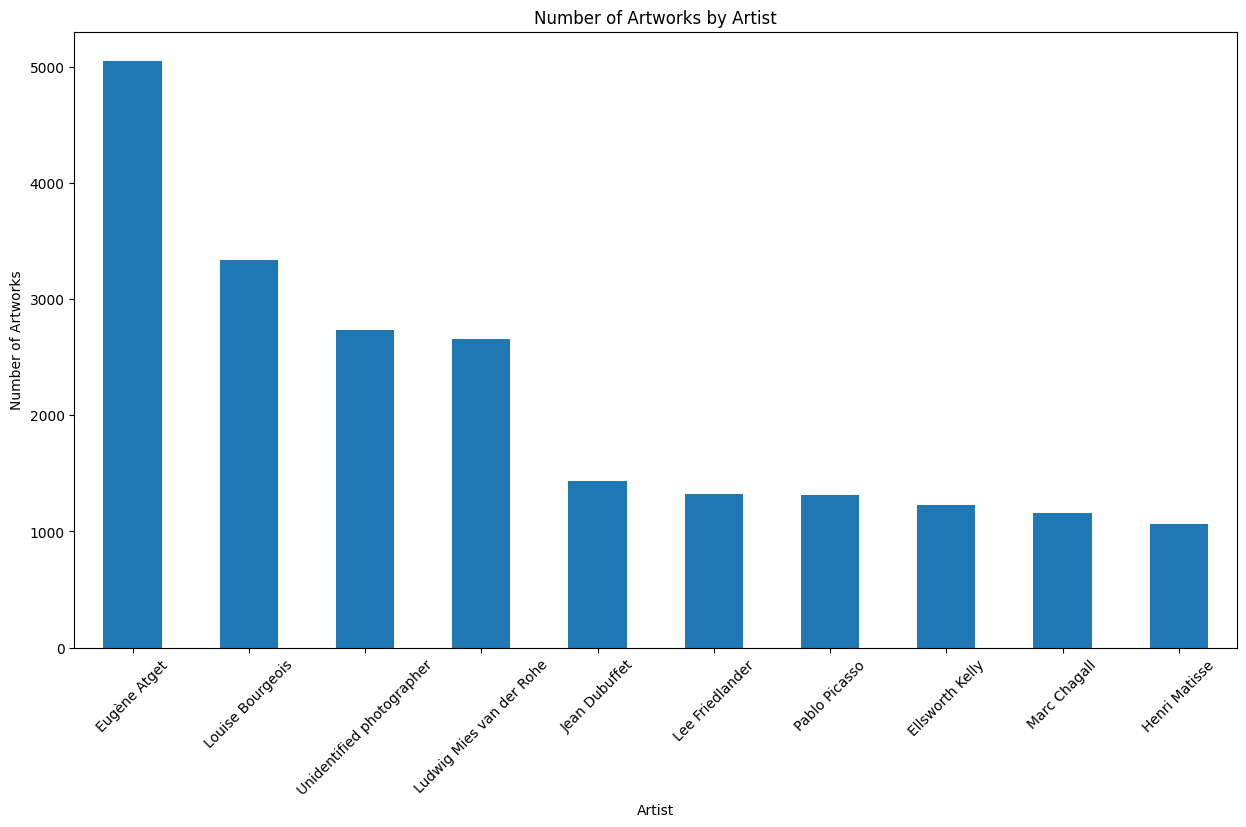

In [73]:
artist_counts = artworkdf['Artist'].value_counts()

plt.figure(figsize=(15, 8))
artist_counts.head(10).plot(kind='bar')
plt.title('Number of Artworks by Artist')
plt.xlabel('Artist')
plt.ylabel('Number of Artworks')
plt.xticks(rotation=45)
plt.show()

## catalogue

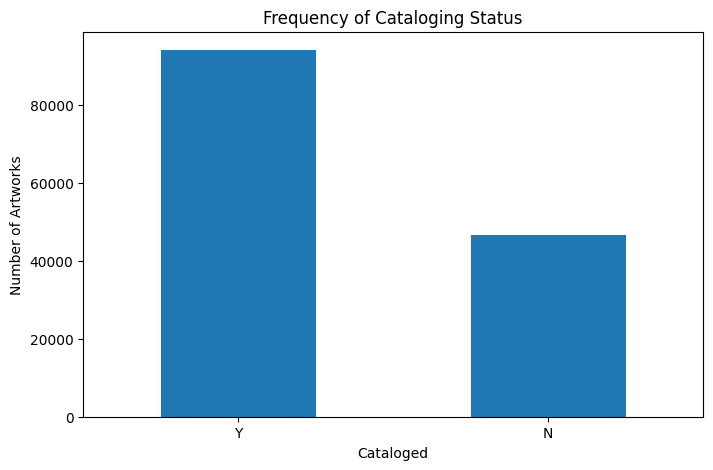

In [80]:
cataloged_counts = artworkdf['Cataloged'].value_counts()
plt.figure(figsize=(8, 5))
cataloged_counts.plot(kind='bar')
plt.title('Frequency of Cataloging Status')
plt.xlabel('Cataloged')
plt.ylabel('Number of Artworks')
plt.xticks(rotation=0)
plt.show()

encode creditline and plot it

height and width range

no of artist

# BIVARIATE ANALYSIS FOR ARTWORK

## Artist X no of artwork

In [72]:
artworkdf['Artist'].value_counts()

Eugène Atget                                                             5050
Louise Bourgeois                                                         3336
Unidentified photographer                                                2738
Ludwig Mies van der Rohe                                                 2657
Jean Dubuffet                                                            1435
                                                                         ... 
Ferdinand Porsche                                                           1
Micro Compact Car Smart GmbH, Renningen, Germany, and Hambach, France       1
Willys-Overland Motors, Inc., Toledo, Ohio                                  1
Frank Hurley                                                                1
Abdoulaye Konaté                                                            1
Name: Artist, Length: 13696, dtype: int64

classifcation X department

gender with nationality

## Get the common Width  for each Classification

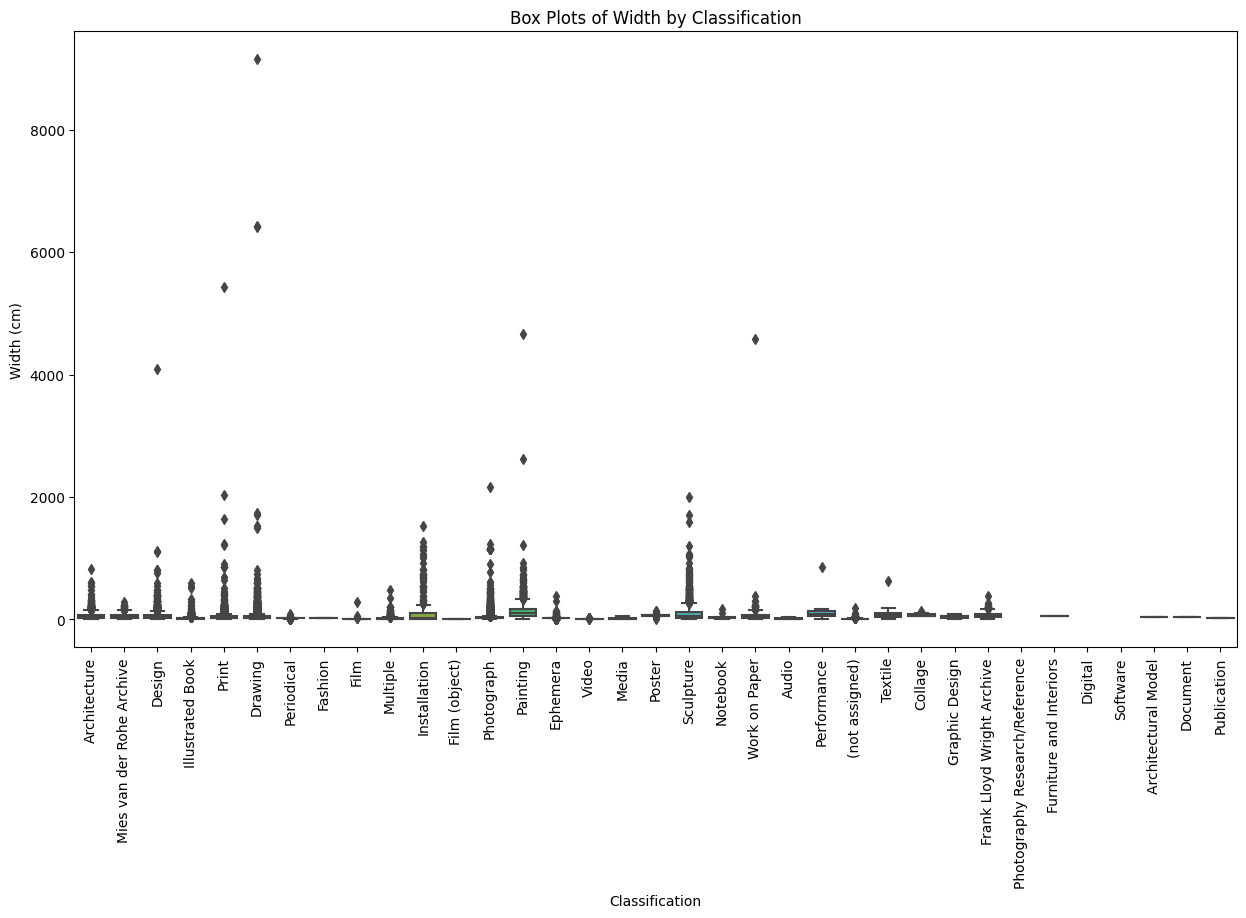

In [53]:
plt.figure(figsize=(15, 8))
sns.boxplot(x='Classification', y='Width (cm)', data=artworkdf)
plt.xticks(rotation=90)
plt.title('Box Plots of Width by Classification')
plt.xlabel('Classification')
plt.ylabel('Width (cm)')
plt.show()

## Relationship between Classification and Department

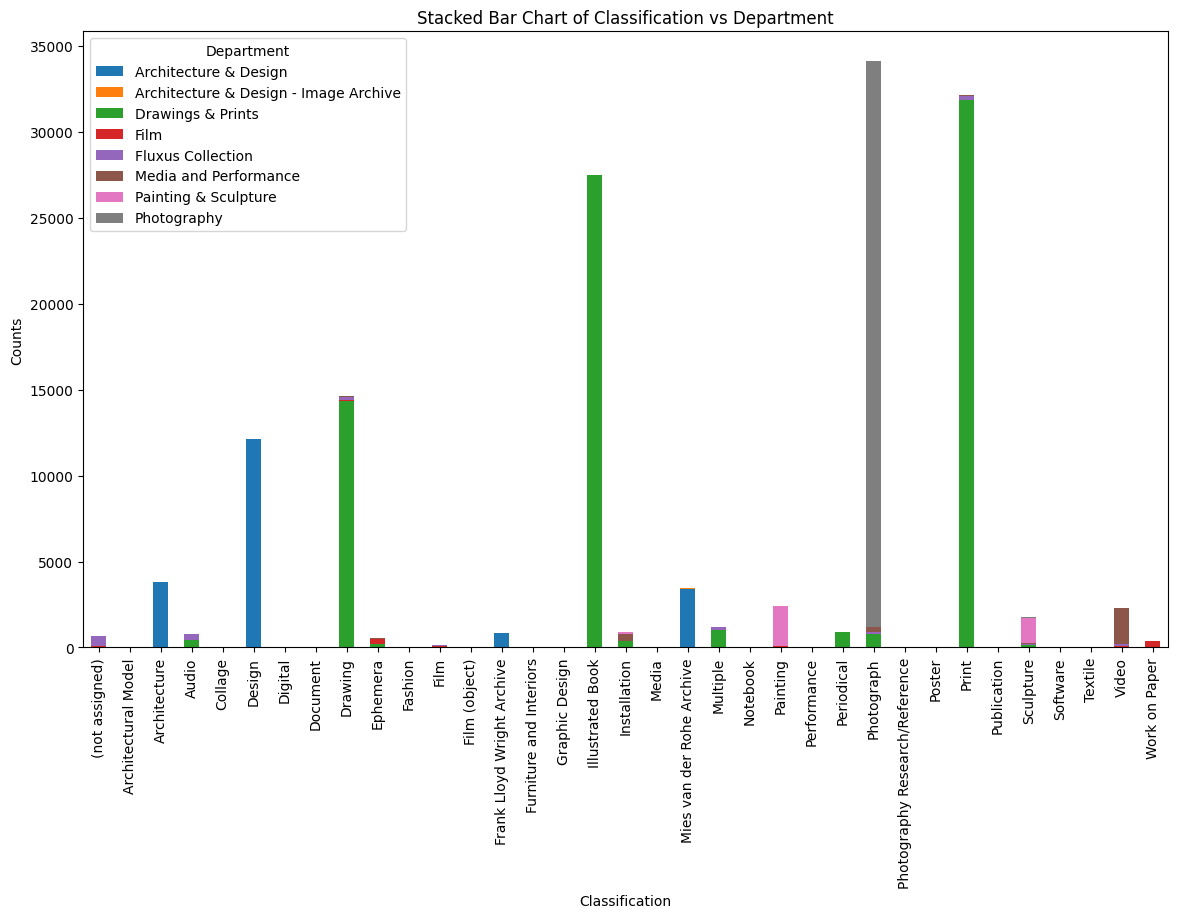

In [74]:
ctab = pd.crosstab(artworkdf['Classification'], artworkdf['Department'])
ctab.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Stacked Bar Chart of Classification vs Department')
plt.xlabel('Classification')
plt.ylabel('Counts')
plt.xticks(rotation=90)
plt.show()

Relationship between Width and Height of Artworks

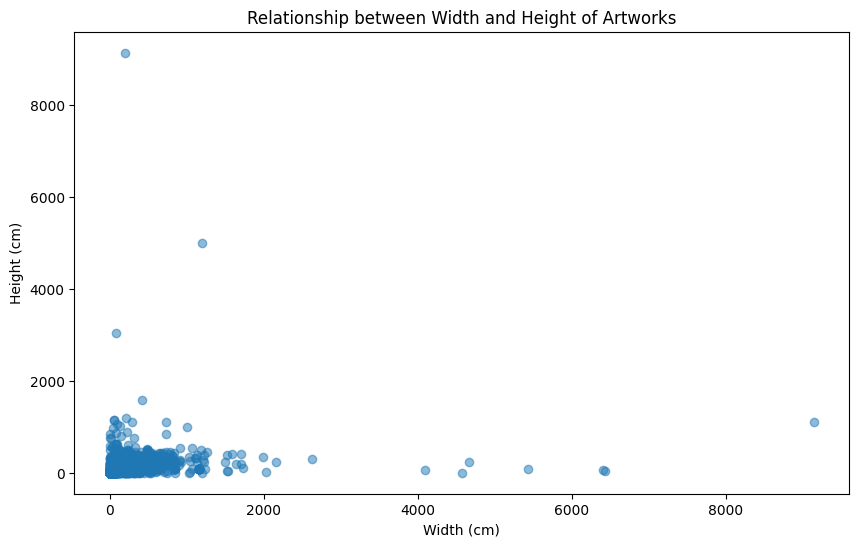

In [81]:
plt.figure(figsize=(10, 6))
plt.scatter(artworkdf['Width (cm)'], artworkdf['Height (cm)'], alpha=0.5)
plt.title('Relationship between Width and Height of Artworks')
plt.xlabel('Width (cm)')
plt.ylabel('Height (cm)')
plt.show()